In [1]:
import numpy as np
import pymc3 as pm
import scipy
from scipy import constants
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from astropy import constants as const
matplotlib.rcParams.update({'font.size': 17,"axes.labelsize": 17})

# Load the eclipse depth and temperature data from Garhart 2020

In [2]:
filename='garhart2020.csv'
garhartDF = pd.read_csv(filename)

Remove the planets that don't have a Ch1 eclipse depth

In [3]:
garhartDF=garhartDF.drop([18,24])

In [4]:
#Split the Tb columns into two
garhartDF[['4.5 μm Tb','4.5 μm Tb err']]=garhartDF['4.5 μm Tb'].str.split('±',expand=True).astype('float')
garhartDF[['3.6 μm Tb','3.6 μm Tb err']]=garhartDF['3.6 μm Tb'].str.split('±',expand=True).astype('float')
garhartDF[['T eq','T eq err']] =garhartDF['Equilibrium temperature'].str.split('±',expand=True).astype('float')

In [5]:
garhartDF

,Planet,Equilibrium temperature,3.6 μm Tb,4.5 μm Tb,4.5 μm Tb err,3.6 μm Tb err,T eq,T eq err
0,HAT-13,1653± 50,1810.0,1754.0,200.0,229.0,1653.0,50.0
1,HAT-30,1718± 34,2087.0,1938.0,160.0,140.0,1718.0,34.0
2,HAT-33,1855± 148,2112.0,1990.0,209.0,162.0,1855.0,148.0
3,HAT-40,1771± 38,2074.0,1887.0,259.0,354.0,1771.0,38.0
4,HAT-41,1685± 58,1694.0,1622.0,125.0,294.0,1685.0,58.0
5,KELT-2,1721± 36,1994.0,1782.0,111.0,104.0,1721.0,36.0
6,KELT-3,1829± 42,2445.0,2132.0,133.0,133.0,1829.0,42.0
7,KELT-7,2056± 31,2512.0,2415.0,73.0,69.0,2056.0,31.0
8,Qatar-1,1422± 36,1410.0,1532.0,219.0,425.0,1422.0,36.0
9,WASP-12,2546± 82,3329.0,2934.0,114.0,172.0,2546.0,82.0


# Reformat this a bit to make it play nicer with PYMC3
"Stack" the data so that I can use a single Normal distribution for both channels, and create indices. This makes my life easier when I want to compare the WAIC, LOO, etc. etc. Give a unique index for each planet name, and for the Spitzer IRAC Channel.

In [6]:
ch2DF=garhartDF[['Planet','4.5 μm Tb','4.5 μm Tb err','T eq','T eq err']].copy()
ch1DF=garhartDF[['Planet','3.6 μm Tb','3.6 μm Tb err','T eq','T eq err']].copy()
ch2DF.columns= ['Planet','Tday','Terr','T eq','T eq err']
ch1DF.columns= ['Planet','Tday','Terr','T eq','T eq err']
ch2DF['Planet Ind']=np.arange(0,37)
ch2DF['Channel']=np.ones(37,dtype=int)*0
ch1DF['Planet Ind']=np.arange(0,37)
ch1DF['Channel']=np.ones(37,dtype=int)*1

In [7]:
df_cleaned=pd.concat([ch2DF,ch1DF])

In [8]:
pd.set_option('display.max_rows', 1000)

In [9]:
df_cleaned

,Planet,Tday,Terr,T eq,T eq err,Planet Ind,Channel
0,HAT-13,1754.0,200.0,1653.0,50.0,0,0
1,HAT-30,1938.0,160.0,1718.0,34.0,1,0
2,HAT-33,1990.0,209.0,1855.0,148.0,2,0
3,HAT-40,1887.0,259.0,1771.0,38.0,3,0
4,HAT-41,1622.0,125.0,1685.0,58.0,4,0
5,KELT-2,1782.0,111.0,1721.0,36.0,5,0
6,KELT-3,2132.0,133.0,1829.0,42.0,6,0
7,KELT-7,2415.0,73.0,2056.0,31.0,7,0
8,Qatar-1,1532.0,219.0,1422.0,36.0,8,0
9,WASP-12,2934.0,114.0,2546.0,82.0,9,0


# Scale the dayside temperature by dividing by the irradiation temperature and add this as a new column

In [10]:
# Scale the temperatures to get m values
df_cleaned['m']=df_cleaned['Tday']/df_cleaned['T eq']*0.25**0.25
df_cleaned['m err']=df_cleaned['Terr']/df_cleaned['T eq']*0.25**0.25


# The non-hierarchical model

In [29]:
with pm.Model() as model_sep:
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    m = pm.Deterministic('m',1+0.5*m_offset)
    #Calculate the brightness temp ratio
    #ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    
    #Convert m to brightness temp
    Tday = pm.Deterministic('Tday',m*df_cleaned['T eq'])
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y',mu=Tday , sd=df_cleaned['Terr'],observed= df_cleaned['Tday'])

# Plot predictive posterior check to make sure the priors are giving reasonable values.

In [30]:
with model_sep:
    ppc_sep =pm.sample_prior_predictive(samples=1000)

Text(0.5, 0, '$T_{0}$')

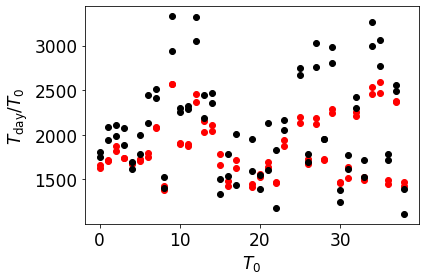

In [31]:
plt.scatter(x=df_cleaned.index,y=np.median(ppc_sep['Tday'],axis=0),color='red')
plt.scatter(x=df_cleaned.index,y=df_cleaned['Tday'],color='k')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')

# Fit and sample the separate model. We expect this to just reproduce the published results.

In [32]:
with model_sep:
    trace_sep =pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:16<00:00, 479.31draws/s]


In [37]:
summary=pm.summary(trace_sep,var_names=['Tday'],round_to=7)

Text(0.5, 0, '$T_{0}$ (K)')

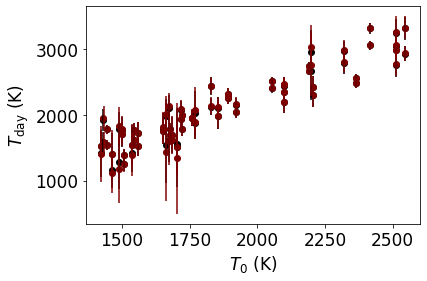

In [39]:
plt.errorbar(x=df_cleaned['T eq'],y=summary['mean'],yerr=summary['sd'],linestyle='None',color='k')
plt.scatter(x=df_cleaned['T eq'],y=summary['mean'],color='k')
plt.errorbar(x=df_cleaned['T eq']+0.2,y=df_cleaned['Tday'],yerr=df_cleaned['Terr'],linestyle='None',color='maroon')
plt.scatter(x=df_cleaned['T eq'],y=df_cleaned['Tday'],color='maroon')
plt.ylabel(r'$T_{\rm day}$ (K)')
plt.xlabel(r'$T_{0}$ (K)')

In [41]:

summary_ratio=pm.summary(trace_sep,var_names=['Tday'],round_to=7)


In [42]:
summary_ratio

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Tday[0],1749.192558,197.939166,1376.421858,2102.967042,1.940685,1.372310,10402.873631,10402.873631,10352.463504,2989.603787,1.000373
Tday[1],1930.830783,152.537719,1633.620108,2197.616420,1.482437,1.064364,10587.714542,10269.964057,10595.418346,2872.619000,1.002967
Tday[2],1983.378266,203.897406,1611.417872,2354.064832,2.145228,1.549266,9033.927974,8661.048736,9086.806592,2692.770531,1.001409
Tday[3],1875.585037,248.701655,1378.845435,2324.689026,2.276985,1.649967,11929.906956,11360.546944,11944.196304,2245.279420,1.004985
Tday[4],1620.419257,124.565540,1398.837996,1867.137021,1.122526,0.821115,12314.107789,11507.463829,12530.991602,2810.920014,1.000562
Tday[5],1781.122865,107.415371,1575.806534,1982.087491,1.077608,0.764782,9935.991528,9863.995771,9923.868170,3005.083823,1.001148
Tday[6],2126.357624,130.063069,1891.384020,2375.899441,1.408343,0.995883,8528.867432,8528.867432,8546.379325,3094.390826,1.002837
Tday[7],2412.455948,72.999764,2281.389823,2559.036144,0.719119,0.508509,10304.837354,10304.837354,10269.102408,2936.604668,1.000316
Tday[8],1521.321411,210.078770,1131.056886,1909.968105,2.130010,1.546822,9727.498584,9223.184076,9722.540968,2802.923913,1.000609
Tday[9],2929.522880,114.644452,2725.353445,3149.405316,1.173891,0.831747,9537.856150,9499.925229,9510.861327,3214.300936,1.000826


# The hierarchical models

The first model will be a wavelength independent hierarchical model--- a common hierarchical distribution for both channels. 

In [43]:
Tdaymean = np.array((df_cleaned[0:37]['Tday'].mean(),df_cleaned[37:37*2]['Tday'].mean()))
Teqmean =df_cleaned[0:37]['T eq'].mean()
Tdaymean, Teqmean

(array([2058.7027027 , 2132.64864865]), 1860.6486486486488)

In [44]:
with pm.Model() as model_hier_ind:
    m_hier_offset = pm.Normal('m hier offset',0,1)
    m_hier = pm.Deterministic('m hier',1+0.5*m_hier_offset)
    
    b_offset = pm.Normal('b offset',0,1)
    b = pm.Deterministic('b',2200+500*b_offset)
    
    m_sig = pm.HalfNormal('m sig',500)
    
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    Tday = pm.Deterministic('Tday',m_hier*(df_cleaned['T eq']-Teqmean)+b+m_sig*m_offset)

    #Calculate the brightness temp ratio
    #ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y',mu=Tday , sd=df_cleaned['Terr'],observed= df_cleaned['Tday'])

# First do a prior predictive check.

In [45]:
with model_hier_ind:
    ppc_hier_ind =pm.sample_prior_predictive(samples=1000)

Text(0.5, 0, '$T_{0}$')

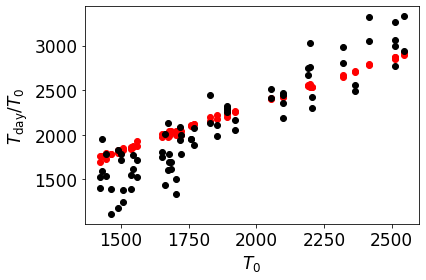

In [46]:
plt.scatter(x=df_cleaned['T eq'],y=np.median(ppc_hier_ind['Tday'],axis=0),color='red')
plt.scatter(x=df_cleaned['T eq'],y=df_cleaned['Tday'],color='k')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')

In [47]:
with model_hier_ind:
    trace_hier_ind =pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset, m sig, b offset, m hier offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:20<00:00, 390.99draws/s]


In [48]:
summary_hier_ind=pm.summary(trace_hier_ind,var_names=['Tday'],round_to=7)
#summary_ratio_ind=pm.summary(trace_hier_ind,var_names=['ratio'],round_to=7)

# Plot the brightness temperatures for the dataset.

In [103]:
lineparams=pm.summary(trace_hier_ind,var_names=['m hier','m sig','b'],round_to=7)

In [104]:
lineparams

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m hier,1.426643,0.073380,1.284409,1.558221,0.001773,0.001254,1713.545412,1713.545412,1714.766083,2754.920635,1.003407
m sig,149.518360,21.721235,107.916166,188.962000,0.510752,0.361215,1808.625130,1808.625130,1808.727022,2839.676518,0.999425
b,2122.998542,24.996127,2076.618517,2169.971461,0.658420,0.465668,1441.248268,1441.248268,1439.916572,2619.883487,1.000486


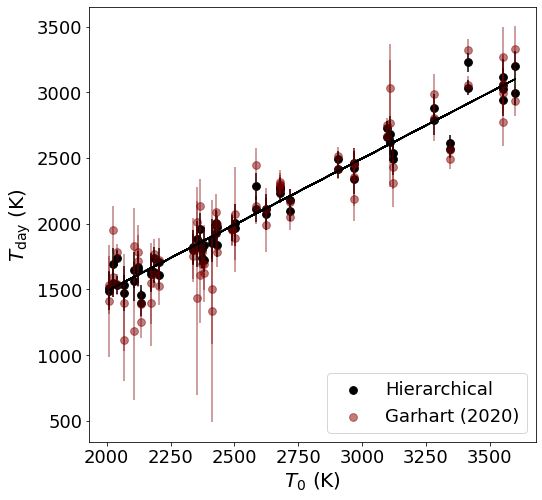

In [105]:

plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 18,"axes.labelsize": 20})

plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_ind['mean'],yerr=summary_hier_ind['sd'],linestyle='None',color='k')
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_ind['mean'],color='k',s=60,label='Hierarchical')
plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['Tday'],yerr=df_cleaned['Terr'],linestyle='None',color='maroon',alpha=0.5)
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['Tday'],color='maroon',s=60,alpha=0.5,label='Garhart (2020)')
plt.plot(df_cleaned['T eq']/(0.25**0.25),lineparams['mean']['m hier']*(df_cleaned['T eq']-Teqmean)+lineparams['mean']['b'],color='k')
#plt.axhline((2/3)**0.25,color='gray')
#plt.axhline(0.5**0.25,color='gray',linestyle='dashed')
#plt.axhline(0.25**0.25,color='gray',linestyle='dotted')
plt.ylabel(r'$T_{\rm day}$ (K)')
plt.xlabel(r'$T_{0}$ (K)')
#plt.ylim(0.18,1.1)
plt.legend(loc=4)
plt.savefig('Garhart_Hier_2channel_line.pdf',bbox_inches='tight')

In [106]:
T0 =df_cleaned['T eq']/(0.25**0.25)

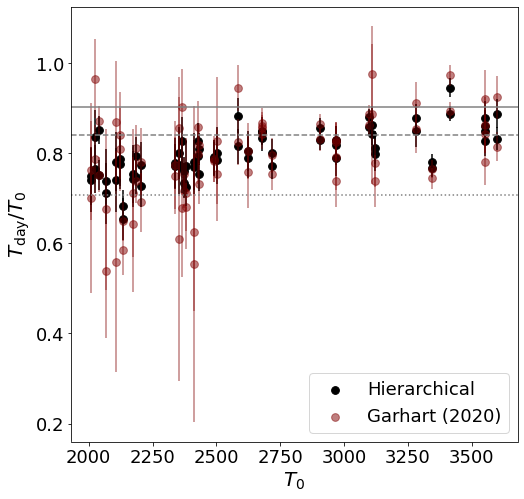

In [107]:

plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 18,"axes.labelsize": 20})

plt.errorbar(x=T0,y=summary_hier_ind['mean']/T0.values,yerr=summary_hier_ind['sd']/T0.values,linestyle='None',color='k')
plt.scatter(x=T0,y=summary_hier_ind['mean']/T0.values,color='k',s=60,label='Hierarchical')
plt.errorbar(x=T0,y=df_cleaned['m'],yerr=df_cleaned['m err'],linestyle='None',color='maroon',alpha=0.5)
plt.scatter(x=T0,y=df_cleaned['m'],color='maroon',s=60,alpha=0.5,label='Garhart (2020)')
plt.axhline((2/3)**0.25,color='gray')
plt.axhline(0.5**0.25,color='gray',linestyle='dashed')
plt.axhline(0.25**0.25,color='gray',linestyle='dotted')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')
#plt.ylim(0.18,1.1)
plt.legend(loc=4)
plt.savefig('Garhart_Hier_Line_Ind.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x138fbaa30>,
      dtype=object)

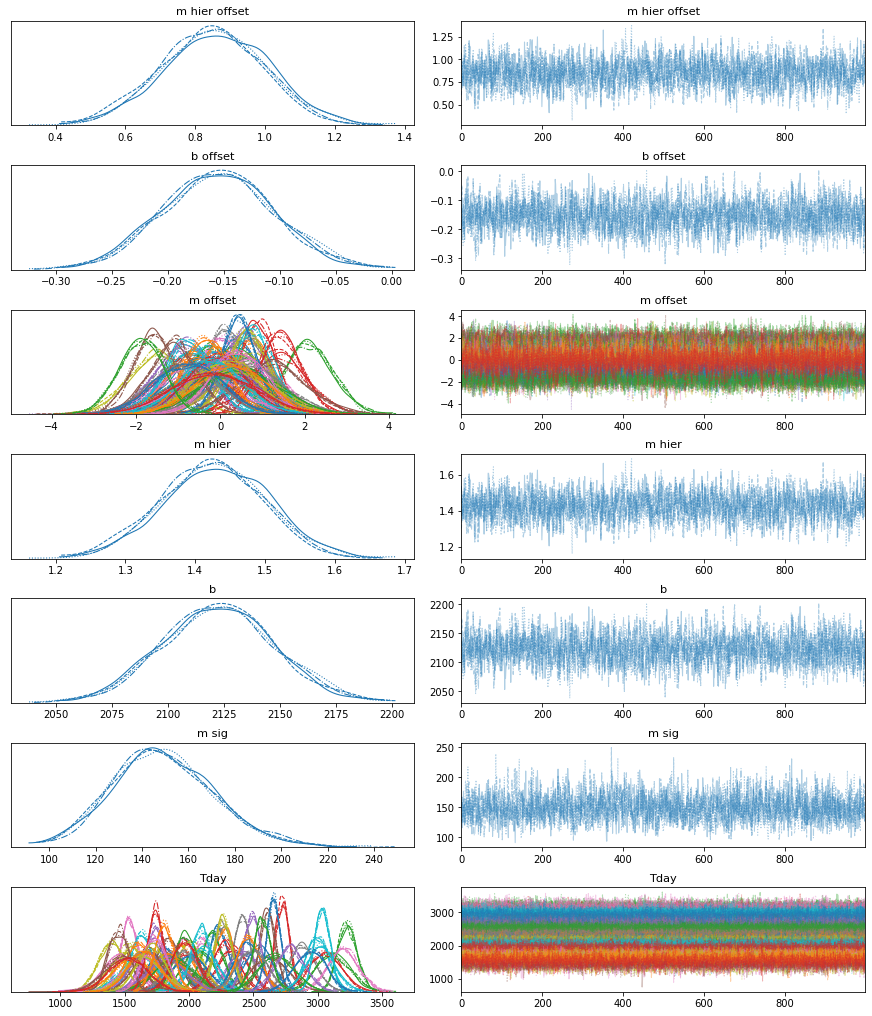

In [62]:
pm.traceplot(trace_hier_ind)

# Now fit wavelength dependent slopes and intercepts.

In [69]:
with pm.Model() as model_hier_sep:
    m_hier_offset = pm.Normal('m hier offset',0,1,shape=2)
    m_hier = pm.Deterministic('m hier',1+0.5*m_hier_offset)
    
    b_offset = pm.Normal('b offset',0,1,shape=2)
    b = pm.Deterministic('b',2200+500*b_offset)
    
    m_sig = pm.HalfNormal('m sig',500,shape=2)
    
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    Tday = pm.Deterministic('Tday',m_hier[df_cleaned['Channel']]*(df_cleaned['T eq']-Teqmean)
                            +b[df_cleaned['Channel']]+m_sig[df_cleaned['Channel']]*m_offset)

    #Calculate the brightness temp ratio
    #ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y',mu=Tday , sd=df_cleaned['Terr'],observed= df_cleaned['Tday'])

In [70]:
with model_hier_sep:
    trace_hier_sep =pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset, m sig, b offset, m hier offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:28<00:00, 279.58draws/s]
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

In [85]:
summary_hier_sep = pm.summary(trace_hier_sep,varnames=['Tday'])

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/stats/__init__.py:19: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


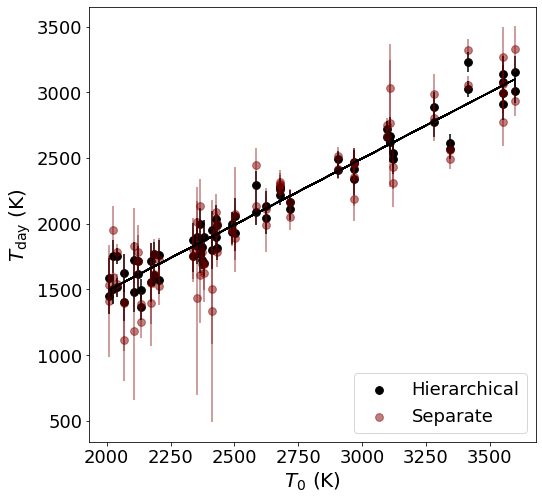

In [90]:

plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 18,"axes.labelsize": 20})

plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_sep['mean'],yerr=summary_hier_sep['sd'],linestyle='None',color='k')
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=summary_hier_sep['mean'],color='k',s=60,label='Hierarchical')
plt.errorbar(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['Tday'],yerr=df_cleaned['Terr'],linestyle='None',color='maroon',alpha=0.5)
plt.scatter(x=df_cleaned['T eq']/(0.25**0.25),y=df_cleaned['Tday'],color='maroon',s=60,alpha=0.5,label='Separate')
plt.plot(df_cleaned['T eq']/(0.25**0.25),lineparams['mean']['m hier']*(df_cleaned['T eq']-Teqmean)+lineparams['mean']['b'],color='k')
#plt.axhline((2/3)**0.25,color='gray')
#plt.axhline(0.5**0.25,color='gray',linestyle='dashed')
#plt.axhline(0.25**0.25,color='gray',linestyle='dotted')
plt.ylabel(r'$T_{\rm day}$ (K)')
plt.xlabel(r'$T_{0}$ (K)')
#plt.ylim(0.18,1.1)
plt.legend(loc=4)
plt.savefig('Garhart_Hier_2channel_line_sep.pdf',bbox_inches='tight')

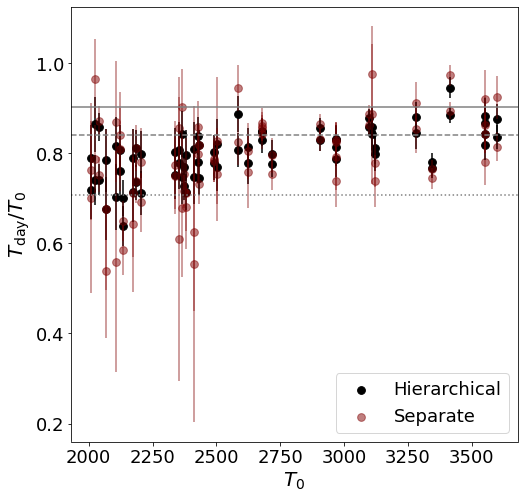

In [88]:

plt.figure(figsize=(8,8))
matplotlib.rcParams.update({'font.size': 18,"axes.labelsize": 20})

plt.errorbar(x=T0,y=summary_hier_sep['mean']/T0.values,yerr=summary_hier_sep['sd']/T0.values,linestyle='None',color='k')
plt.scatter(x=T0,y=summary_hier_sep['mean']/T0.values,color='k',s=60,label='Hierarchical')
plt.errorbar(x=T0,y=df_cleaned['m'],yerr=df_cleaned['m err'],linestyle='None',color='maroon',alpha=0.5)
plt.scatter(x=T0,y=df_cleaned['m'],color='maroon',s=60,alpha=0.5,label='Separate')
plt.axhline((2/3)**0.25,color='gray')
plt.axhline(0.5**0.25,color='gray',linestyle='dashed')
plt.axhline(0.25**0.25,color='gray',linestyle='dotted')
plt.ylabel(r'$T_{\rm day}/T_{0}$')
plt.xlabel(r'$T_{0}$')
#plt.ylim(0.18,1.1)
plt.legend(loc=4)
plt.savefig('Garhart_Hier_Line_Sep.pdf',bbox_inches='tight')

# Try a model where the slopes are drawn from a hierarchical distribution.

In [93]:
with pm.Model() as model_hier_squared:
    m_hier_hier_offset = pm.Normal('m hier hier offset',0,1)
    m_hier_hier = pm.Deterministic('m hier hier',1+0.5*m_hier_hier_offset)
    
    m_hier_offset = pm.Normal('m hier offset',0,1,shape=2)
    m_hier = pm.Deterministic('m hier',m_hier_hier+0.5*m_hier_offset)
    
    b_hier_offset = pm.Normal('b hier offset',0,1)
    b_hier = pm.Deterministic('b hier',2200+500*b_hier_offset)
    b_offset = pm.Normal('b offset',0,1,shape=2)
    b = pm.Deterministic('b',b_hier+500*b_offset)
    
    m_sig = pm.HalfNormal('m sig',500,shape=2)
    
    m_offset = pm.Normal('m offset',0,1,shape=len(df_cleaned.index))
    Tday = pm.Deterministic('Tday',m_hier[df_cleaned['Channel']]*(df_cleaned['T eq']-Teqmean)
                            +b[df_cleaned['Channel']]+m_sig[df_cleaned['Channel']]*m_offset)

    #Calculate the brightness temp ratio
    #ratio =pm.Deterministic('ratio',m[0:37]/m[37:74])
    #Convert m to brightness temp
    #Tday = pm.Deterministic('Tday',m*Teff[2::]*np.sqrt(1/a[2::]))
    #ED= pm.Deterministic('ED',Planck(4.5e-6,Tday)/BStarCh2[2::]*radius[2::]**2)
    y_= pm.Normal('y',mu=Tday , sd=df_cleaned['Terr'],observed= df_cleaned['Tday'])

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [94]:
with model_hier_squared:
    trace_hier_squared = pm.sample(draws=1000,tune=1000,chains=4,cores=4,target_accept =0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m offset, m sig, b offset, b hier offset, m hier offset, m hier hier offset]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [02:35<00:00, 51.53draws/s]
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an 

# Compare the WAIC values for the three models.

In [92]:
pm.compare({'Wavelength Independent':trace_hier_sep,'Wavelength Dependent':trace_hier_ind,
            'Non-Hierarchical':trace_sep},ic='waic')

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1409: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAI

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Wavelength Dependent,0,-490.194,23.0875,0,0.518271,4.22105,0,True,log
Wavelength Independent,1,-490.44,23.5757,0.246613,0.477921,4.45225,1.80828,True,log
Non-Hierarchical,2,-501.287,33.0349,11.0928,0.00380769,4.57455,3.60798,True,log


In [95]:
pm.compare({'Wavelength Independent':trace_hier_sep,'Wavelength Dependent':trace_hier_ind,
            'Non-Hierarchical':trace_sep,'Hierarchical Squared':trace_hier_squared},ic='waic')

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:1409: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Hierarchical Squared,0,-490.002,23.2641,0,0.369423,4.48341,0,True,log
Wavelength Dependent,1,-490.194,23.0875,0.191576,0.385286,4.60845,1.77932,True,log
Wavelength Independent,2,-490.44,23.5757,0.438189,0.244454,4.47476,0.413387,True,log
Non-Hierarchical,3,-501.287,33.0349,11.2844,0.000836965,4.45175,3.58109,True,log


In [83]:
pm.summary(trace_hier_ind,varnames=['m hier','b'])

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/stats/__init__.py:19: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m hier,1.427,0.073,1.284,1.558,0.002,0.001,1714.0,1714.0,1715.0,2755.0,1.0
b,2122.999,24.996,2076.619,2169.971,0.658,0.466,1441.0,1441.0,1440.0,2620.0,1.0


In [84]:
pm.summary(trace_hier_sep,varnames=['m hier','b'])

/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/pymc3/stats/__init__.py:19: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  warnings.warn(
/Users/dylanskeating/opt/miniconda3/envs/pymc3/lib/python3.8/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
m hier[0],1.542,0.105,1.345,1.737,0.002,0.002,1857.0,1857.0,1859.0,2459.0,1.0
m hier[1],1.277,0.102,1.082,1.461,0.003,0.002,1615.0,1575.0,1621.0,1885.0,1.0
b[0],2081.007,35.883,2017.044,2150.798,0.892,0.631,1619.0,1619.0,1621.0,2165.0,1.0
b[1],2166.205,35.187,2099.043,2232.638,1.026,0.726,1175.0,1175.0,1182.0,1768.0,1.0


# Put the refit brightness temperatures into a CSV.

In [96]:
summary_hier_ind

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Tday[0],1801.530842,118.684196,1575.674935,2023.543157,1.558853,1.102331,5796.624964,5796.624964,5776.638793,2775.650144,1.001495
Tday[1],1928.107387,107.479860,1733.268477,2132.394282,1.391647,0.984091,5964.799184,5964.799184,5984.288430,2769.800199,1.000822
Tday[2],2073.357735,118.955114,1855.007465,2298.105092,1.504948,1.064209,6247.741400,6247.741400,6253.907578,3404.695898,0.999941
Tday[3],1965.720850,133.398989,1699.667031,2201.769554,1.747741,1.235901,5825.740304,5825.740304,5842.017475,3195.508305,1.000648
Tday[4],1725.326339,96.506511,1532.207732,1893.438903,1.199956,0.854298,6468.190324,6381.231021,6433.643066,3135.086506,1.000307
Tday[5],1835.286294,91.712537,1664.809132,2002.487607,1.193048,0.847748,5909.372621,5852.437129,5865.025429,2834.424598,1.001131
Tday[6],2108.194930,99.007216,1925.178707,2297.662323,1.203511,0.854219,6767.585573,6717.427343,6762.712282,2857.446058,1.001056
Tday[7],2412.176849,66.552276,2290.955370,2545.002209,0.756298,0.535923,7743.542411,7711.221164,7722.149113,2857.175369,1.000384
Tday[8],1508.064010,128.308440,1261.900552,1748.873803,1.727322,1.227515,5517.772153,5463.527087,5510.966968,3046.133585,1.000304
Tday[9],2995.401042,91.601272,2811.621181,3154.080560,1.134385,0.803343,6520.517140,6501.445987,6548.670592,2547.231430,1.000571


In [97]:
m_fit = []
garhart_tday = []
garhart_m = []
tdayfit =[]
tirr = []
channel =df_cleaned['Channel']
planet = []
for ind,obs in enumerate(summary_hier_ind['mean']):
    #print(df_cleaned['Planet'].values[ind],obs,summary_hier['sd'][ind])
    planet.append(str(df_cleaned['Planet'].values[ind])+' b')
    tirr.append(str(int((df_cleaned['T eq'].values[ind]/0.25**0.25).round(0)))+'$\pm$'+str(int((df_cleaned['T eq err'].values[ind]/0.25**0.25).round(0))))
    #m_fit.append(str(summary_hier_ind['mean'][ind].round(2))+'$\pm$'+str(summary_hier_ind['sd'][ind].round(2)))
    garhart_tday.append(str(int(df_cleaned['Tday'].round(0).values[ind]))+'$\pm'+str(int(df_cleaned['Terr'].round(0).values[ind])))
    tdayfit.append(str(int((summary_hier_ind['mean'][ind]).round(0)))+
                  '$\pm$'+str(int((summary_hier_ind['sd'][ind]).round(0))))
    #garhart_m.append(str((df_cleaned['m'].round(2).values[ind]))+'$\pm'+str(df_cleaned['m err'].round(2).values[ind]))

In [98]:
channel=np.zeros(len(tdayfit))
channel[0:37] = 2
channel[37:74]=1

In [101]:
d = {'Planet':planet,'$T_{0}$':tirr,'Channel':channel.astype(int),
     'Tday':tdayfit}

In [102]:
result =pd.DataFrame(d)
result.to_csv('Garhart_2020_Results.csv',index=False)